# Solving a PDE


\begin{aligned}
u_t(x,t) &= u_{xx}(x,t)\\
u(x, 0) &= \sin(x)\\
u(0,t ) &= 0\\
u(\pi,t) &= 0.
\end{aligned}
with the exact solution:
$$
y(x) = \sin(x) e^{-t}
$$

In [1]:
import torch

In [2]:
x = torch.linspace(0, torch.pi, 50, requires_grad=True)
t = torch.linspace(0, 1, 50, requires_grad=True)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)

In [3]:
from torch import nn

In [4]:
mlp = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
)

In [5]:
import torch.optim as optim

optimizer = optim.Adam(list(mlp.parameters()), lr=0.05)

In [6]:
def dy_dx(y, x):
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

In [7]:
losses = []

for i in range(1500):
    x_t = torch.cat((x, t), 1)
    x_0 = torch.cat((x, 0 * t), 1)
    z_t = torch.cat((0 * x, t), 1)
    pi_t = torch.cat((torch.pi + 0 * x, t), 1)

    u = mlp.forward(x_t)
    u_t = dy_dx(u, t)
    u_x = dy_dx(u, x)
    u_xx = dy_dx(u_x, x)

    residual_pde = u_t - u_xx

    residual_init = mlp.forward(x_0) - torch.sin(x)
    residual_bdy1 = mlp.forward(z_t) - 0
    residual_bdy2 = mlp.forward(pi_t) - 0

    loss = (
        (residual_pde**2).mean()
        + (residual_init**2).mean()
        + (residual_bdy1**2).mean()
        + (residual_bdy2**2).mean()
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().numpy())

    if i % 10 == 0:
        print("Epoch %3d: Current loss: %.2e" % (i, losses[-1]))

Epoch   0: Current loss: 9.61e-01
Epoch  10: Current loss: 3.92e-01
Epoch  20: Current loss: 2.84e-01
Epoch  30: Current loss: 1.76e-01
Epoch  40: Current loss: 7.62e-02
Epoch  50: Current loss: 2.68e-02
Epoch  60: Current loss: 9.23e-03
Epoch  70: Current loss: 4.55e-03
Epoch  80: Current loss: 2.62e-03
Epoch  90: Current loss: 2.03e-03
Epoch 100: Current loss: 1.69e-03
Epoch 110: Current loss: 1.36e-03
Epoch 120: Current loss: 1.16e-03
Epoch 130: Current loss: 1.01e-03
Epoch 140: Current loss: 8.86e-04
Epoch 150: Current loss: 7.81e-04
Epoch 160: Current loss: 6.92e-04
Epoch 170: Current loss: 6.18e-04
Epoch 180: Current loss: 5.97e-04
Epoch 190: Current loss: 2.16e-02
Epoch 200: Current loss: 5.95e-03
Epoch 210: Current loss: 2.86e-03
Epoch 220: Current loss: 9.72e-04
Epoch 230: Current loss: 5.37e-04
Epoch 240: Current loss: 4.49e-04
Epoch 250: Current loss: 3.94e-04
Epoch 260: Current loss: 3.27e-04
Epoch 270: Current loss: 3.10e-04
Epoch 280: Current loss: 2.89e-04
Epoch 290: Cur

In [8]:
Nx, Nt = 31, 21
x = torch.linspace(0, torch.pi, Nx)
t = torch.linspace(0, 1, Nt)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)
x_t = torch.cat((x, t), 1)

exact = (torch.sin(x) * torch.exp(-t)).reshape(Nx, Nt)
predict = mlp.forward(x_t).reshape(Nx, Nt)
error = exact - predict

MAE = torch.abs(error).mean()

print("Mean Absolute Error: %.2e" % MAE)

Mean Absolute Error: 6.87e-04


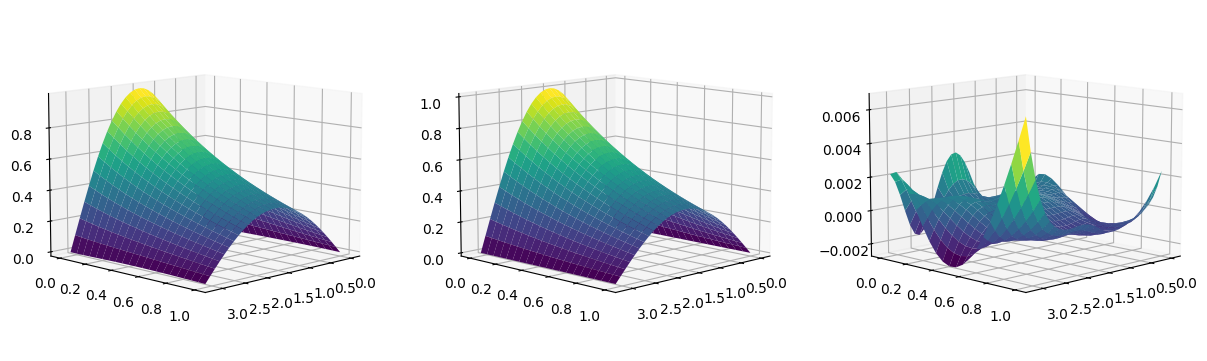

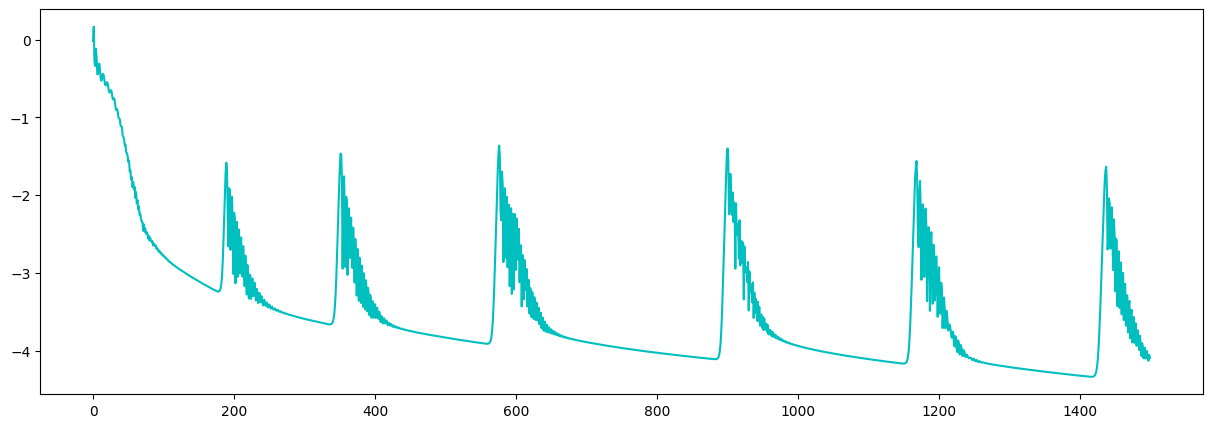

In [9]:
import matplotlib.pyplot as plt
import numpy as np

x = x.reshape(Nx, Nt)
t = t.reshape(Nx, Nt)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection="3d")
ax.plot_surface(x, t, predict.detach().numpy(), cmap="viridis")
ax.view_init(10, 45)

ax = fig.add_subplot(132, projection="3d")
ax.plot_surface(x, t, exact.detach().numpy(), cmap="viridis")
ax.view_init(10, 45)
ax = fig.add_subplot(133, projection="3d")
ax.plot_surface(x, t, error.detach().numpy(), cmap="viridis")
ax.view_init(10, 45)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(np.log10(losses), "c", label="Loss")